In [1]:
# import sys; sys.path.append('/rds/general/user/cb2714/home/23-05_canada-wildfires'); from fwi import *
import sys; sys.path.append('/rds/general/user/cb2714/home/'); from wwa import *

sf = gpd.read_file("sf_ejb/").to_crs(epsg = 4326)

## **CRCM5 processing**
HR = hurs; I5 = snw; PR = pr; TT = tas   
UU & VV converted to windspeed (WS) using CDO before uploading: `cdo -s chname,uas,sfcWind -sqrt -add -sqr -selname,uas $u_file -sqr -selname,vas $v_file $file_out`  
Each variable concatenated into a single file using CDO  

In [2]:
path_in = "../00_WWA_project_folder/ephemeral/canada_fwi/99_processing/crcm5_catted/"
path_out = "../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/crcm5/"

In [ ]:
# aggregate precip to daily
pr = xr.open_dataset(cat_path+"crcm5_PR_catted.nc").pr
pr24 = pr.rolling(time = 24, center = False).sum()
pr24h = pr24.groupby("time.hour")[18]
convert_units_to(pr24h, "mm/day").to_netcdf(path_out+"pr_1800_CRCM5.nc")

In [3]:
# convert all other variables to the required units
convert_units_to(xr.open_dataset(path_in+"crcm5_TT_catted.nc").tas, "degC").to_netcdf(path_out+"tas_1800_CRCM5.nc")
convert_units_to(xr.open_dataset(path_in+"crcm5_HR_catted.nc").hurs, "%").to_netcdf(path_out+"hurs_1800_CRCM5.nc")
convert_units_to(xr.open_dataset(path_in+"crcm5_WS_catted.nc").sfcWind, "km/hr").to_netcdf(path_out+"sfcWind_1800_CRCM5.nc")
convert_units_to(xr.open_dataset(path_in+"crcm5_I5_catted.nc").snw, "m").to_netcdf(path_out+"snw_1800_CRCM5.nc")

### **Time series for climate explorer**  

In [13]:
fwi = xr.open_dataset("model_fwi/fwi_CRCM5.nc").fwi

sf = gpd.read_file("sf_ejb/").to_crs(cartopy.crs.RotatedPole(pole_longitude = 83, pole_latitude = 42.5))
rm = regionmask.mask_3D_geopandas(sf, fwi.rlon, fwi.rlat).squeeze(drop = True)

In [16]:
xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/99_processing/crcm5/var_HR_194901.nc4")

<xarray.Dataset>
Dimensions:       (time: 31, rlat: 64, rlon: 42)
Coordinates:
  * time          (time) datetime64[ns] 1949-01-01T18:00:00 ... 1949-01-31T18...
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
  * rlon          (rlon) float64 9.79 10.01 10.23 10.45 ... 18.37 18.59 18.81
  * rlat          (rlat) float64 0.97 1.19 1.41 1.63 ... 14.17 14.39 14.61 14.83
Data variables:
    rotated_pole  int32 ...
    hurs          (time, rlat, rlon) float32 ...
Attributes: (12/17)
    CDI:                  Climate Data Interface version 1.9.5 (http://mpimet...
    Conventions:          CF-1.6
    institution:          Universite du Quebec a Montreal
    contact:              roberge.francois@uqam.ca
    model:                CRCM5-GEM3
    model_grid:           NAM-22
    ...                   ...
    microphysics:         CONSUN
    driving_data:         MPIMRHR85
    spectral_nudging:     nil
    frequency:            3h
    product:              output
    CDO:                  Climate Data Operators version 1.9.5 (http://mpimet...

In [15]:
mdl = "CRCM5"
xydims = ["rlat", "rlon"]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## FWI7x FOR CLIMATE EXPLORER

# calculate indices & cut off first year
fwi7x_ts = fwi.rolling(time = 7).mean().resample(time = "AS-JAN").max().isel(time = slice(1, None)).where(rm == 1).mean(xydims).dropna("time", "any")
fwi7x_ts = fwi7x_ts.assign_coords(time = fwi7x_ts.time.dt.year).rename(time = "year")

# specify filename
csv_fnm = "ts/canada-wildfires_fwi7x_"+mdl+".dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: "+mdl+" fwi7x - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# fwi7x [] spatial mean of maximum of 7-day average of FWI over Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year fwi7x"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
fwi7x_ts.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## cumDSR FOR CLIMATE EXPLORER

# compute DSR, set missing values to zero and mask off study region
dsr = (fwi ** 1.71) * 0.0272
dsr = dsr.where(~np.isnan(dsr), 0).where(rm == 1)

cumdsr_ts = dsr.sel(time = [m <= 7 for m in dsr.time.dt.month]).resample(time = "AS-JAN").sum().rename("cumdsr").where(rm == 1).mean(xydims)
cumdsr_ts = cumdsr_ts.assign_coords(time = cumdsr_ts.time.dt.year).rename(time = "year")

# specify filename
csv_fnm = "ts/canada-wildfires_cumDSR_"+mdl+".dat"
if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: "+mdl+" cumulative DSR - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
str2 = "# cumDSR [] spatial mean of cumulative Daily Severity Rating from Jan-July each year over Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year cumDSR"

# make .dat file
! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm
cumdsr_ts.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

## **Calculate FWI**

In [ ]:
tas, pr, sfcWind, snw, hurs = [xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/crcm5/"+varnm+"_1800_CRCM5.nc")[varnm] for varnm in ["tas", "pr", "sfcWind", "snw", "hurs"]]

months = tas.time.dt.month.to_numpy()
days = tas.time.dt.day.to_numpy()

print("  ",datetime.now())
ffmc, dmc, dc, isi, bui, fwi = xr.apply_ufunc(lambda t, p, w, h, s : calculate_fwi(months, days, t, p, w, h, s), tas, pr, sfcWind, hurs, snw, 
                                              input_core_dims = [["time"],["time"],["time"],["time"],["time"]], 
                                              output_core_dims = [["time"],["time"],["time"],["time"],["time"],["time"]], vectorize = True)
print("  ",datetime.now())

da = xr.merge([eval(v).rename(v) for v in ["ffmc", "dmc", "dc", "isi", "bui", "fwi"]])
da.to_netcdf("model_fwi/fwi_CRCM5.nc")

   2023-08-10 17:01:30.978906


/rds/general/user/cb2714/home/23-05_canada-wildfires/fwi.py:182: RuntimeWarning: invalid value encountered in long_scalars
  test = np.sum(test) / len(test) > 0.75
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


---
# **ERA5 pre-processing**
Initial subsetting carried out using CDO  
Concatenation into single file also done using CDO for tas, hurs, sfcWind, snd - only precip aggregated manually

In [2]:
tds = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/era5/downloaded_era5_t2m-d2m-snd.nc").sum("expver", keep_attrs = True)
uv = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/era5/downloaded_era5_u10-v10.nc").sum("expver", keep_attrs = True)
j31 = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/era5/downloaded_era5_July-31st.nc")

In [5]:
xr.concat([tds.t2m, j31.t2m], "time").to_netcdf("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/era5/era5_t2m_19400101-20230731.nc")
xr.concat([tds.d2m, j31.d2m], "time").to_netcdf("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/era5/era5_d2m_19400101-20230731.nc")
xr.concat([tds.sd, j31.sd], "time").to_netcdf("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/era5/era5_sd_19400101-20230731.nc")

xr.concat([uv, j31[["u10","v10"]]], "time").to_netcdf("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/era5/era5_uv_19400101-20230731.nc")

---
# **CORDEX pre-processing**
Initial subsetting carried out using CDO (selindexbox,197,240,135,195) 
Concatenation into single file also done using CDO for tas, hurs, sfcWind, snd - only precip aggregated manually

In [4]:
fpath = "../00_WWA_project_folder/ephemeral/canada_fwi/99_processing/cordex"
cordex_models = ["HadGEM2", "MPI-ESM", "NorESM"]
path_out = "../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cordex/"

In [5]:
for mdl in cordex_models:
    fl = glob.glob(fpath+"/pr_*"+mdl+"*.nc")
    new_fnm = path_out+fl[0].split("/")[-1][:-32]+"24hr-1630.nc"
    da = xr.open_mfdataset(fl).pr
    da = da.rolling(time = 8).sum().groupby("time.hour")[16]
    da.to_netcdf(new_fnm)

---
# **CanESM-CanRCM large ensemble pre-processing**
Initial subsetting carried out using CDO  
Concatenation into single file also done using CDO for tas, hurs, sfcWind, snd - only precip aggregated manually

In [2]:
fpath = "../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/canesm-canrcm/subfiles/"
path_out = "../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/canesm-canrcm/"

In [8]:
for gcm in range(6)[1:]: 
    for rcm in range(8)[1:]:  
        
        fl = sorted(glob.glob(fpath+"pr_*r"+str(gcm)+"_r"+str(rcm)+"*.nc"))
        new_fnm = path_out+fl[0].split("/")[-1][:-28]+"24hr-1800.nc"
        
        da = xr.open_mfdataset(fl).pr
        da = da.rolling(time = 8).sum().groupby("time.hour")[18]
        da.to_netcdf(new_fnm)

---
# **Climate model evaluation**


## **Seasonal cycles**

### **Temperatures**

/var/tmp/pbs.8104071.pbs/ipykernel_2288515/3226494856.py:35: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x1486579a7b20> starts with '_'. It is thus excluded from the legend.
  axs[1,4].legend("_", edgecolor = "w")


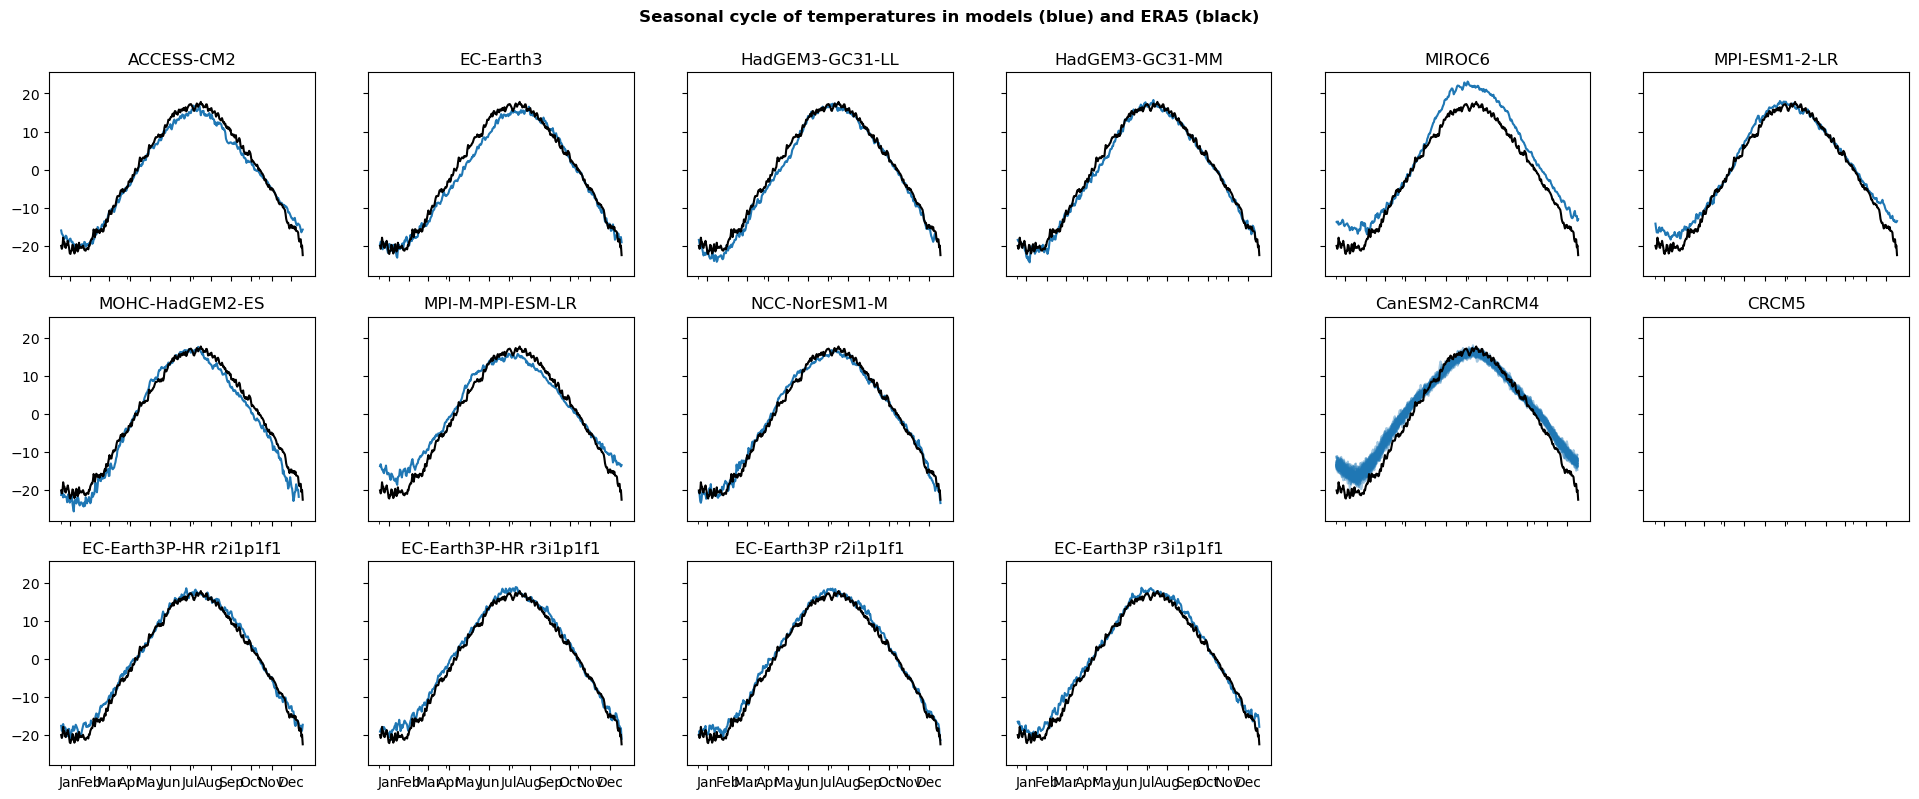

In [72]:
era5_tas = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/era5/era5_t2m_19400101-20230731.nc").t2m.sel(time = slice("1980", "2020"))
era5_tas = convert_units_to(era5_tas.where(regionmask.mask_3D_geopandas(sf, era5_tas.longitude, era5_tas.latitude).squeeze(drop = True) == 1).mean(["latitude", "longitude"]).groupby("time.dayofyear").mean(), "degC")

# pre-load the large ensemble, v slow otherwise
lens = xr.concat([xr.open_dataset(fnm).sel(time = slice("1980", "2020")).tas for fnm in sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/canesm-canrcm/tas_*"))], "member")
lens_sc = convert_units_to(lens.where(regionmask.mask_3D_geopandas(sf, lens.lon, lens.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean(), "degC")

fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (24,9), dpi = 100, sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.2)

cmip6_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cmip6/tas_*"))
for i in range(len(cmip6_fl)):
    ax = axs[0,i]
    da = xr.open_dataset(cmip6_fl[i]).tas.sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    convert_units_to(sc, "degC").plot(ax = ax)
    convert_units_to(era5_tas, "degC").plot(ax = ax, color = "k")
    ax.set_title(cmip6_fl[i].split("_")[7])
    ax.set_ylabel("")
    
cordex_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cordex/tas_*"))
for i in range(len(cordex_fl)):
    ax = axs[1,i]
    fnm = cordex_fl[i]
    da = xr.open_dataset(fnm).tas.sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean()
    convert_units_to(sc, "degC").plot(ax = ax)
    convert_units_to(era5_tas, "degC").plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[7])
axs[1,3].set_axis_off()

lens_sc.to_pandas().transpose().plot(ax = axs[1,4], color = "tab:blue", alpha = 0.4)
convert_units_to(era5_tas, "degC").plot(ax = axs[1,4], color = "k", label = "_")
axs[1,4].set_title("CanESM2-CanRCM4")
axs[1,4].legend("_", edgecolor = "w")

axs[1,5].set_title("CRCM5")

highresmip_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/highresmip/tas/tas_*"))
for i in range(len(highresmip_fl)):
    ax = axs[2,i]
    fnm = highresmip_fl[i]
    da = xr.open_dataset(fnm).tas.sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    convert_units_to(sc, "degC").plot(ax = ax)
    convert_units_to(era5_tas, "degC").plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[6]+" "+fnm.split("_")[8])
for i in range(len(highresmip_fl), 6): axs[2,i].set_axis_off()
    
for ax in fig.axes:
    ax.set_ylabel("")
    ax.set_xlabel("")
    sc_xlabels(dates = pd.date_range(start = "2020-01-01", end = "2020-12-31"), ax = ax, fmt = "%b")

plt.suptitle("Seasonal cycle of temperatures in models (blue) and ERA5 (black)", fontweight = "bold", y = 0.95)
plt.savefig("fig/seasonal-cycle-tas.png")

### **Precipitation**

In [ ]:
lens = xr.concat([xr.open_dataset(fnm).sel(time = slice("1980", "2020")).pr for fnm in sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/canesm-canrcm/pr_*"))], "member")

In [7]:
sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cordex/tas_*"))

In [13]:
lens_proj = cartopy.crs.RotatedPole(pole_longitude = 83, pole_latitude = 43)
sf = sf.to_crs(lens_proj)
da = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/can_lens/r1_r1/tas_NAM-44_CCCma-CanESM2_historical-r1_r1i1p1_CCCma-CanRCM4_r2_3hr_1950010103-1951010100.nc").tas
rm = regionmask.mask_3D_geopandas(sf, da.rlon, da.rlat).squeeze(drop = True)

da.isel(time = -1).plot()
sf.boundary.plot(color = "k", ax = plt.gca())

In [71]:
def scale(ts): return ts / ts.std()

era5_pr = xr.open_dataset("era5_tp_19400101-20230729.nc").tp.sel(time = slice("1980", "2020"))
era5_pr = scale(era5_pr.where(regionmask.mask_3D_geopandas(sf, era5_pr.longitude, era5_pr.latitude).squeeze(drop = True) == 1).mean(["latitude", "longitude"]).groupby("time.dayofyear").mean())

# pre-load the large ensemble, v slow otherwise
lens = xr.concat([xr.open_dataset(fnm).sel(time = slice("1980", "2020")).pr for fnm in sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/canesm-canrcm/pr_*"))], "member")
lens_sc = lens.where(regionmask.mask_3D_geopandas(sf, lens.lon, lens.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean()
lens_sc = lens_sc / lens_sc.std("dayofyear")

fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (24,9), dpi = 100, sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.2)

cmip6_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cmip6/pr_**"))
for i in range(len(cmip6_fl)):
    ax = axs[0,i]
    da = xr.open_dataset(cmip6_fl[i]).pr.sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    scale(sc).plot(ax = ax)
    era5_pr.plot(ax = ax, color = "k")
    ax.set_title(cmip6_fl[i].split("_")[7])
    ax.set_ylabel("")
    
cordex_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cordex/pr_*"))
for i in range(len(cordex_fl)):
    ax = axs[1,i]
    fnm = cordex_fl[i]
    da = xr.open_dataset(fnm).pr.sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean()
    scale(sc).plot(ax = ax)
    era5_pr.plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[7])
axs[1,3].set_axis_off()

lens_sc.to_pandas().transpose().plot(ax = axs[1,4], color = "tab:blue", alpha = 0.4)
era5_pr.plot(ax = axs[1,4], color = "k", label = "_")
axs[1,4].set_title("CanESM2-CanRCM4")
axs[1,4].legend("_", edgecolor = "w")

axs[1,5].set_title("CRCM5")

highresmip_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/highresmip/pr_24h/pr_*"))
for i in range(len(highresmip_fl)):
    ax = axs[2,i]
    fnm = highresmip_fl[i]
    da = xr.open_dataset(fnm).pr.sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    scale(sc).plot(ax = ax)
    era5_pr.plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[6]+" "+fnm.split("_")[8])
for i in range(len(highresmip_fl), 6): axs[2,i].set_axis_off()
    
for ax in fig.axes:
    ax.set_ylabel("")
    ax.set_xlabel("")
    sc_xlabels(dates = pd.date_range(start = "2020-01-01", end = "2020-12-31"), ax = ax)

plt.suptitle("Seasonal cycle of precipitation in models (blue) and ERA5 (black)", fontweight = "bold", y = 0.95)
plt.savefig("fig/seasonal-cycle-pr.png")

### **sfcWind**
Not needed for report, but checking that model data looks ok - hence no conversion or scaling applied

/var/tmp/pbs.8104071.pbs/ipykernel_2288515/2706848611.py:37: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x14865a91a050> starts with '_'. It is thus excluded from the legend.
  axs[1,4].legend("_", edgecolor = "w")


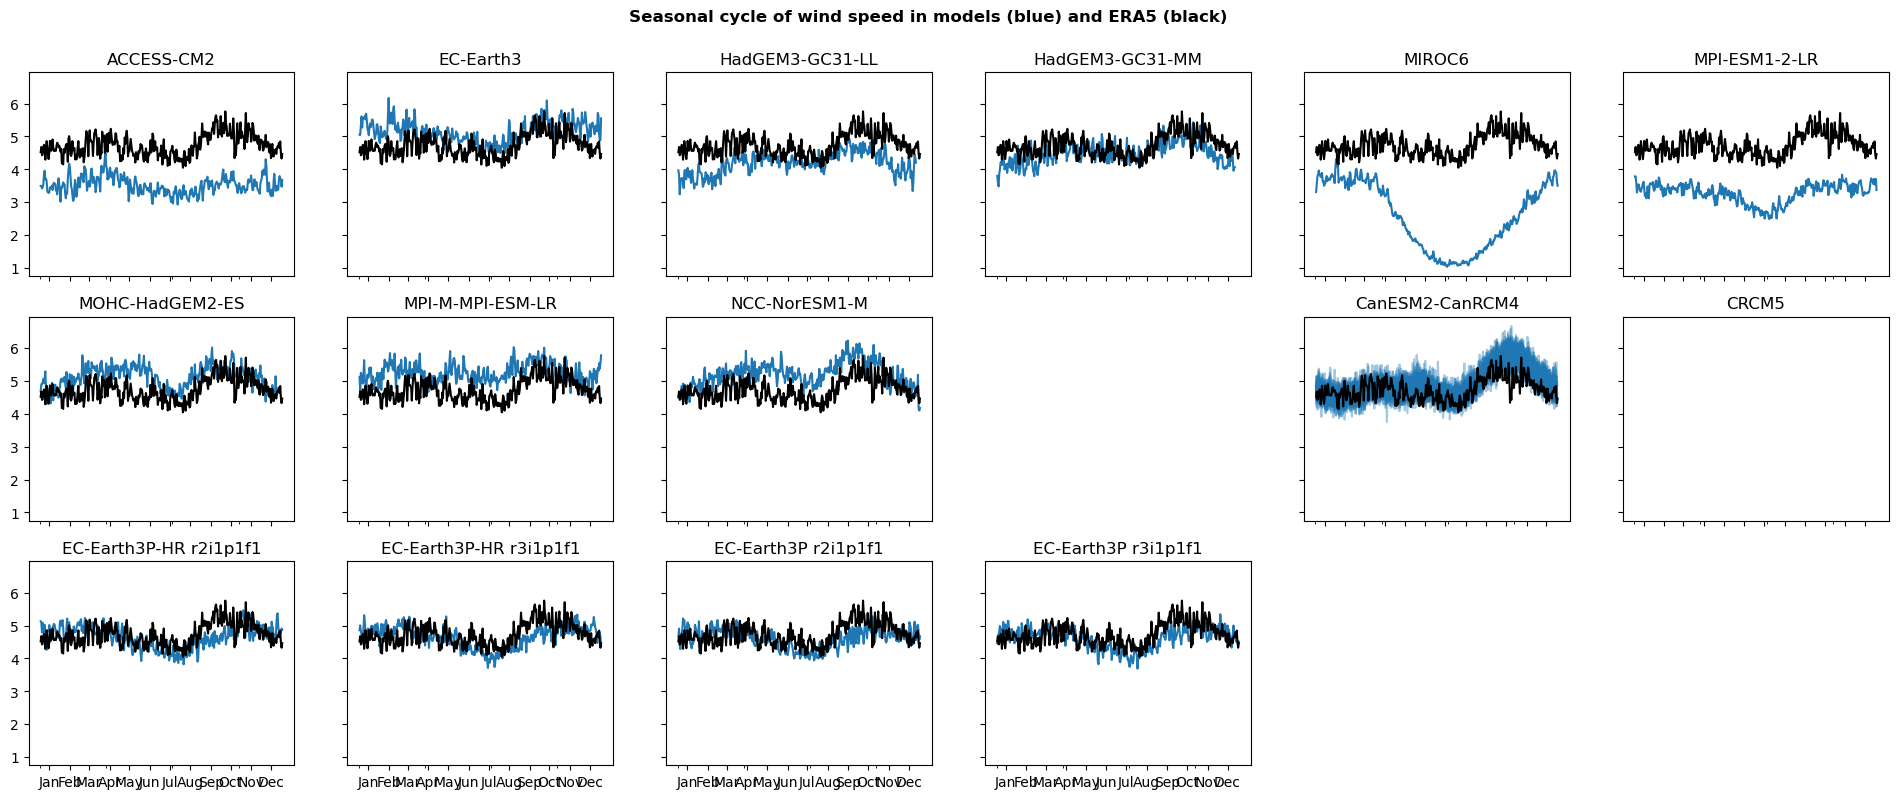

In [73]:
varnm = "sfcWind"

era5 = xr.open_dataset("era5_"+varnm+"_19400101-20230731.nc")[varnm].sel(time = slice("1980", "2020"))
era5_sc = era5.where(regionmask.mask_3D_geopandas(sf, era5.longitude, era5.latitude).squeeze(drop = True) == 1).mean(["latitude", "longitude"]).groupby("time.dayofyear").mean()

# pre-load the large ensemble, v slow otherwise
lens = xr.concat([xr.open_dataset(fnm).sel(time = slice("1980", "2020"))[varnm] for fnm in sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/canesm-canrcm/"+varnm+"_*"))], "member")
lens_sc = lens.where(regionmask.mask_3D_geopandas(sf, lens.lon, lens.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean()

fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (24,9), dpi = 100, sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.2)

cmip6_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cmip6/"+varnm+"_*"))
for i in range(len(cmip6_fl)):
    ax = axs[0,i]
    da = xr.open_dataset(cmip6_fl[i])[varnm].sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    sc.plot(ax = ax)
    era5_sc.plot(ax = ax, color = "k")
    ax.set_title(cmip6_fl[i].split("_")[7])
    ax.set_ylabel("")
    
cordex_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cordex/"+varnm+"_*"))
for i in range(len(cordex_fl)):
    ax = axs[1,i]
    fnm = cordex_fl[i]
    da = xr.open_dataset(fnm)[varnm].sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean()
    sc.plot(ax = ax)
    era5_sc.plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[7])
axs[1,3].set_axis_off()

lens_sc.to_pandas().transpose().plot(ax = axs[1,4], color = "tab:blue", alpha = 0.4)
era5_sc.plot(ax = axs[1,4], color = "k", label = "_")
axs[1,4].set_title("CanESM2-CanRCM4")
axs[1,4].legend("_", edgecolor = "w")

axs[1,5].set_title("CRCM5")

highresmip_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/highresmip/"+varnm+"/"+varnm+"_*"))
for i in range(len(highresmip_fl)):
    ax = axs[2,i]
    fnm = highresmip_fl[i]
    da = xr.open_dataset(fnm)[varnm].sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    sc.plot(ax = ax)
    era5_sc.plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[6]+" "+fnm.split("_")[8])
for i in range(len(highresmip_fl), 6): axs[2,i].set_axis_off()
    
for ax in fig.axes:
    ax.set_ylabel("")
    ax.set_xlabel("")
    sc_xlabels(dates = pd.date_range(start = "2020-01-01", end = "2020-12-31"), ax = ax)
    
plt.suptitle("Seasonal cycle of wind speed in models (blue) and ERA5 (black)", fontweight = "bold", y = 0.95)
plt.savefig("fig/seasonal-cycle-sfcWind.png")

### **hurs**
Not needed for report, but checking that model data looks ok - hence no conversion or scaling applied

/var/tmp/pbs.8104071.pbs/ipykernel_2288515/622929365.py:37: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x148656eb17e0> starts with '_'. It is thus excluded from the legend.
  axs[1,4].legend("_", edgecolor = "w")


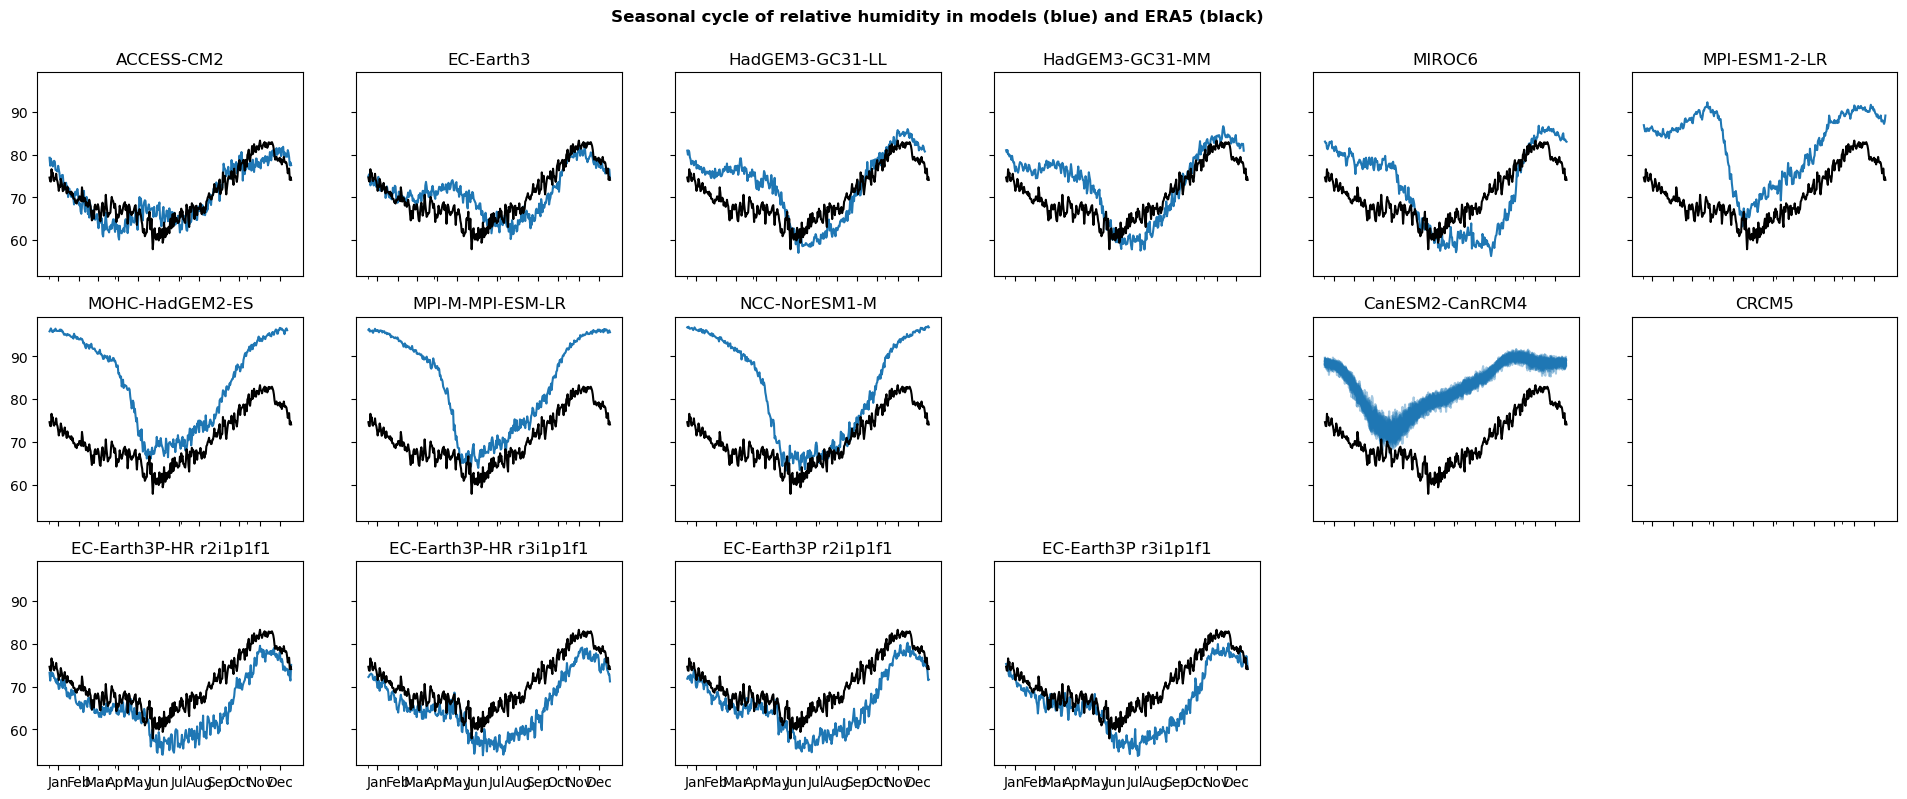

In [74]:
varnm = "hurs"

era5 = xr.open_dataset("era5_"+varnm+"_19400101-20230731.nc")[varnm].sel(time = slice("1980", "2020"))
era5_sc = era5.where(regionmask.mask_3D_geopandas(sf, era5.longitude, era5.latitude).squeeze(drop = True) == 1).mean(["latitude", "longitude"]).groupby("time.dayofyear").mean()

# pre-load the large ensemble, v slow otherwise
lens = xr.concat([xr.open_dataset(fnm).sel(time = slice("1980", "2020"))[varnm] for fnm in sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/canesm-canrcm/"+varnm+"_*"))], "member")
lens_sc = lens.where(regionmask.mask_3D_geopandas(sf, lens.lon, lens.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean()

fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (24,9), dpi = 100, sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.2)

cmip6_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cmip6/"+varnm+"_*"))
for i in range(len(cmip6_fl)):
    ax = axs[0,i]
    da = xr.open_dataset(cmip6_fl[i])[varnm].sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    sc.plot(ax = ax)
    era5_sc.plot(ax = ax, color = "k")
    ax.set_title(cmip6_fl[i].split("_")[7])
    ax.set_ylabel("")
    
cordex_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cordex/"+varnm+"_*"))
for i in range(len(cordex_fl)):
    ax = axs[1,i]
    fnm = cordex_fl[i]
    da = xr.open_dataset(fnm)[varnm].sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean()
    sc.plot(ax = ax)
    era5_sc.plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[7])
axs[1,3].set_axis_off()

lens_sc.to_pandas().transpose().plot(ax = axs[1,4], color = "tab:blue", alpha = 0.4)
era5_sc.plot(ax = axs[1,4], color = "k", label = "_")
axs[1,4].set_title("CanESM2-CanRCM4")
axs[1,4].legend("_", edgecolor = "w")

axs[1,5].set_title("CRCM5")

highresmip_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/highresmip/"+varnm+"/"+varnm+"_*"))
for i in range(len(highresmip_fl)):
    ax = axs[2,i]
    fnm = highresmip_fl[i]
    da = xr.open_dataset(fnm)[varnm].sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    sc.plot(ax = ax)
    era5_sc.plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[6]+" "+fnm.split("_")[8])
for i in range(len(highresmip_fl), 6): axs[2,i].set_axis_off()
    
for ax in fig.axes:
    ax.set_ylabel("")
    ax.set_xlabel("")
    sc_xlabels(dates = pd.date_range(start = "2020-01-01", end = "2020-12-31"), ax = ax)
    
plt.suptitle("Seasonal cycle of relative humidity in models (blue) and ERA5 (black)", fontweight = "bold", y = 0.95)
plt.savefig("fig/seasonal-cycle-hurs.png")

### **snow depth**
Not needed for report, but checking that model data looks ok - hence no conversion or scaling applied

In [87]:
varnm = "sd"
era5 = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/era5/era5_"+varnm+"_19400101-20230731.nc")[varnm].sel(time = slice("1980", "2020"))
era5_sc = era5.where(regionmask.mask_3D_geopandas(sf, era5.longitude, era5.latitude).squeeze(drop = True) == 1).mean(["latitude", "longitude"]).groupby("time.dayofyear").mean()

# pre-load the large ensemble, v slow otherwise
varnm = "snd"
lens = xr.concat([xr.open_dataset(fnm).sel(time = slice("1980", "2020"))[varnm] for fnm in sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/canesm-canrcm/"+varnm+"_*"))], "member")
lens_sc = lens.where(regionmask.mask_3D_geopandas(sf, lens.lon, lens.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean()

varnm = "snw"
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (24,9), dpi = 100, sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.2)

cmip6_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cmip6/"+varnm+"_*"))
for i in range(len(cmip6_fl)):
    ax = axs[0,i]
    da = xr.open_dataset(cmip6_fl[i])[varnm].sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    sc.plot(ax = ax)
    era5_sc.plot(ax = ax, color = "k", ylim = [0,250])
    ax.set_title(cmip6_fl[i].split("_")[7])
    ax.set_ylabel("")
    
cordex_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cordex/"+varnm+"_*"))
for i in range(len(cordex_fl)):
    ax = axs[1,i]
    fnm = cordex_fl[i]
    da = xr.open_dataset(fnm)[varnm].sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["rlat", "rlon"]).groupby("time.dayofyear").mean()
    sc.plot(ax = ax)
    era5_sc.plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[7])
axs[1,3].set_axis_off()

lens_sc.to_pandas().transpose().plot(ax = axs[1,4], color = "tab:blue", alpha = 0.4)
era5_sc.plot(ax = axs[1,4], color = "k", label = "_")
axs[1,4].set_title("CanESM2-CanRCM4")
axs[1,4].legend("_", edgecolor = "w")

axs[1,5].set_title("CRCM5")

highresmip_fl = sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/highresmip/"+varnm+"/"+varnm+"_*"))
for i in range(len(highresmip_fl)):
    ax = axs[2,i]
    fnm = highresmip_fl[i]
    da = xr.open_dataset(fnm)[varnm].sel(time = slice("1980", "2020"))
    sc = da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).groupby("time.dayofyear").mean()
    sc.plot(ax = ax)
    era5_sc.plot(ax = ax, color = "k")
    ax.set_title(fnm.split("_")[6]+" "+fnm.split("_")[8])
for i in range(len(highresmip_fl), 6): axs[2,i].set_axis_off()
    
for ax in fig.axes:
    ax.set_ylabel("")
    ax.set_xlabel("")
    sc_xlabels(dates = pd.date_range(start = "2020-01-01", end = "2020-12-31"), ax = ax)
    
plt.suptitle("Seasonal cycle of snow depth in models (blue) and ERA5 (black)", fontweight = "bold", y = 0.95)
plt.savefig("fig/seasonal-cycle-snw.png")


## **Spatial patterns**

### **CanESM large ensemble**

In [148]:
# lat-lon bounds for Canada
xn = 360-145; xx = 360-50; yn = 40; yx = 80

tmplt = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/can_lens/r1_r1/tas_NAM-44_CCCma-CanESM2_historical-r1_r1i1p1_CCCma-CanRCM4_r2_3hr_1950010103-1951010100.nc")
rm = np.logical_and(np.logical_and(tmplt.lon >= xn, tmplt.lon <= xx), np.logical_and(tmplt.lat >= yn, tmplt.lat <= yx))
rm = rm.where(rm == 1).dropna("rlon", "all").dropna("rlat", "all")

In [164]:
ens_tas = []
for fp in sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/can_lens/r[0-9]_r[0-9]")):
    print(fp, end = "")
    fl = glob.glob(fp+"/tas_*.nc")
    fl = [fnm for fnm in fl if (fnm[-13:-9] >= "1980") and (fnm[-24:-20] <= "2010")]
    
    em = []
    for fnm in fl:
        print(".", end = "")
        em.append(xr.open_dataset(fnm).tas.sel(rlon = rm.rlon, rlat = rm.rlat).groupby("time.season")["JJA"].mean("time"))
    ens_tas.append(xr.concat(em, "time"))
    print("")

lens_tas = convert_units_to(xr.concat(ens_tas, "member").mean("member"), "degC")
lens_tas.to_netcdf("sp-tas_NAM-44_CCCma-CanESM2_CCCma-CanRCM4_r2.nc")

In [174]:
ens_pr = []
for fp in sorted(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/can_lens/r[0-9]_r[0-9]")):
    print(fp, end = "")
    fl = glob.glob(fp+"/pr_*.nc")
    fl = [fnm for fnm in fl if (fnm[-13:-9] >= "1980") and (fnm[-24:-20] <= "2010")]
    
    em = []
    for fnm in fl:
        print(".", end = "")
        da = xr.open_dataset(fnm).pr.sel(rlon = rm.rlon, rlat = rm.rlat)
        em.append(da.sel(time = [m in [3,4,5,6,7] for m in da.time.dt.month]))
    em = xr.concat(em, "time").mean("time")
    ens_pr.append(xr.concat(em, "time"))
    print("")

lens_pr = convert_units_to(xr.concat(zz, "member").mean("member"), "mm/day")
lens_pr.to_netcdf("sp-pr_NAM-44_CCCma-CanESM2_CCCma-CanRCM4_r2.nc")

### **CORDEX**

In [22]:
# lat-lon bounds for Canada
xn = 360-145; xx = 360-50; yn = 40; yx = 80

tmplt = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/synda/data/MOHC-HadGEM2-ES/r1i1p1/REMO2015/tas/tas_NAM-22_MOHC-HadGEM2-ES_historical_r1i1p1_GERICS-REMO2015_v1_3hr_197001010100-197012302200.nc")
rm = np.logical_and(np.logical_and(tmplt.lon >= xn, tmplt.lon <= xx), np.logical_and(tmplt.lat >= yn, tmplt.lat <= yx))
rm = rm.where(rm == 1).dropna("rlon", "all").dropna("rlat", "all")

In [41]:
for fp in glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/synda/data/*/r1i1p1/REMO2015/tas")[1:]:
    
    print(fp, end = "")
    fl = glob.glob(fp+"/*.nc")
    fl = [fnm for fnm in fl if (fnm[-15:-11] >= "1980") & (fnm[-28:-24] <= "2010")]
    
    em = []
    for fnm in fl:
        print(".", end = "")
        em.append(xr.open_dataset(fnm).tas.sel(rlon = rm.rlon, rlat = rm.rlat).groupby("time.season")["JJA"].mean("time"))
    em = convert_units_to(xr.concat(em, "time").mean("time"), "degC")
    em.to_netcdf("sp-"+"_".join(fl[0].split("/")[-1].split("_")[:-2])+".nc")
    print("")
print("Done.")

../00_WWA_project_folder/ephemeral/canada_fwi/synda/data/MOHC-HadGEM2-ES/r1i1p1/REMO2015/tas................................./00_WWA_project_folder/ephemeral/canada_fwi/synda/data/NCC-NorESM1-M/r1i1p1/REMO2015/tas...............................

In [ ]:
for fp in glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/synda/data/*/r1i1p1/REMO2015/pr"):
    
    print(fp, end = "")
    fl = glob.glob(fp+"/*.nc")
    fl = [fnm for fnm in fl if (fnm[-15:-11] >= "1980") & (fnm[-28:-24] <= "2010")]
    
    em = []
    for fnm in fl:
        print(".", end = "")
        da = xr.open_dataset(fnm).pr.sel(rlon = rm.rlon, rlat = rm.rlat)
        em.append(da.sel(time = [m in [3,4,5,6,7] for m in da.time.dt.month]))
    em = convert_units_to(xr.concat(em, "time").mean("time"), "mm/day")
    em.to_netcdf("sp-"+"_".join(fl[0].split("/")[-1].split("_")[:-2])+".nc")
    print("")
print("Done.")

../00_WWA_project_folder/ephemeral/canada_fwi/synda/data/MPI-M-MPI-ESM-LR/r1i1p1/REMO2015/pr...

---
## **Manual calculation of FWI for CMIP6**
_About 5-10 minutes per run_

In [13]:
fpath = "../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cmip6/"
fl = ["_".join(fnm.split("_")[-4:]) for fnm in glob.glob(fpath+"tas_*.nc")]

In [14]:
for fnm in fl[1:]:
    
    print(fnm)
        
    # load data & align timestamps
    tas = convert_units_to(xr.open_mfdataset(fpath+"tas_*"+fnm).tas.sel(time = slice("1850", "2049")).load(), "degC")
    pr = convert_units_to(xr.open_mfdataset(fpath+"pr_*"+fnm).pr.load(), "mm/day")
    sfcWind = convert_units_to(xr.open_mfdataset(fpath+"sfcWind_*"+fnm).sfcWind.load(), "km/hr")
    hurs = xr.open_mfdataset(fpath+"hurs_*"+fnm).hurs.load()
    snw = convert_units_to(xr.open_mfdataset(fpath+"snw_*"+fnm).snw.load(), "m")
    
    P, W, H, S = [da.sel(lon = tas.lon, lat = tas.lat, time = slice("1850", "2049")).assign_coords(time = tas.time) for da in [pr, sfcWind, hurs, snw]]

    if not all([len(da.time) == len(tas.time) for da in [P, W, H, S]]):
        print("   ! length mismatch - skipping")
        continue
        
    months = tas.time.dt.month.to_numpy()
    days = tas.time.dt.day.to_numpy()
    
    print("  ",datetime.now())
    ffmc, dmc, dc, isi, bui, fwi = xr.apply_ufunc(lambda t, p, w, h, s : calculate_fwi(months, days, t, p, w, h, s), tas, P, W, H, S, 
                                                  input_core_dims = [["time"],["time"],["time"],["time"],["time"]], 
                                                  output_core_dims = [["time"],["time"],["time"],["time"],["time"],["time"]], vectorize = True)
    print("  ",datetime.now())
    
    da = xr.merge([eval(v).rename(v) for v in ["ffmc", "dmc", "dc", "isi", "bui", "fwi"]])
    da.to_netcdf("model_fwi/fwi_"+fnm)

MIROC6_historical_r1i1p1f1_gn.nc
   2023-08-08 14:46:48.494852


/rds/general/user/cb2714/home/23-05_canada-wildfires/fwi.py:182: RuntimeWarning: invalid value encountered in long_scalars
  test = np.sum(test) / len(test) > 0.75
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   2023-08-08 14:53:32.536111
EC-Earth3_historical_r1i1p1f1_gr.nc
   2023-08-08 14:53:40.411494


/rds/general/user/cb2714/home/23-05_canada-wildfires/fwi.py:182: RuntimeWarning: invalid value encountered in long_scalars
  test = np.sum(test) / len(test) > 0.75
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   2023-08-08 15:17:28.263627
MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc
   2023-08-08 15:17:29.900278


/rds/general/user/cb2714/home/23-05_canada-wildfires/fwi.py:182: RuntimeWarning: invalid value encountered in long_scalars
  test = np.sum(test) / len(test) > 0.75
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   2023-08-08 15:21:36.466224
HadGEM3-GC31-MM_historical_r1i1p1f3_gn.nc
   2023-08-08 15:21:45.658303


/rds/general/user/cb2714/home/23-05_canada-wildfires/fwi.py:182: RuntimeWarning: invalid value encountered in long_scalars
  test = np.sum(test) / len(test) > 0.75
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   2023-08-08 15:48:18.768538
ACCESS-CM2_historical_r1i1p1f1_gn.nc


ValueError: conflicting sizes for dimension 'time': length 73049 on <this-array> and length 36525 on {'time': 'time', 'lat': 'lat', 'lon': 'lon'}

---
## **Manual calculation of FWI for highresMIP**
_About ten minutes per run_

In [ ]:
fpath = "../00_WWA_project_folder/ephemeral/canada_fwi/highresmip/"
fl = ["_".join(fnm.split("_")[-4:]) for fnm in glob.glob(fpath+"tas/*.nc")]

for fnm in fl[:1]:
    
    print(fnm)
        
    # load data & align timestamps
    tas = convert_units_to(xr.open_mfdataset(fpath+"tas/*"+fnm).tas.load(), "degC")
    pr = convert_units_to(xr.open_mfdataset(fpath+"pr_24h/*"+fnm).pr.load(), "mm/day")
    sfcWind = convert_units_to(xr.open_mfdataset(fpath+"sfcWind/*"+fnm).sfcWind.load(), "km/hr")
    hurs = xr.open_mfdataset(fpath+"hurs/*"+fnm).hurs.load()
    snw = convert_units_to(xr.open_mfdataset(fpath+"snw/*"+fnm).snw.load(), "m")
    
    P, W, H, S = [da.sel(lon = tas.lon, lat = tas.lat).assign_coords(time = tas.time) for da in [pr, sfcWind, hurs, snw]]

    if not all([len(da.time) == len(tas.time) for da in [P, W, H, S]]):
        print("   ! length mismatch - skipping")
        continue
        
    months = tas.time.dt.month.to_numpy()
    days = tas.time.dt.day.to_numpy()
    
    print("  ",datetime.now())
    ffmc, dmc, dc, isi, bui, fwi = xr.apply_ufunc(lambda t, p, w, h, s : calculate_fwi(months, days, t, p, w, h, s), tas, P, W, H, S, 
                                                  input_core_dims = [["time"],["time"],["time"],["time"],["time"]], 
                                                  output_core_dims = [["time"],["time"],["time"],["time"],["time"],["time"]], vectorize = True)
    print("  ",datetime.now())
    
    da = xr.merge([eval(v).rename(v) for v in ["ffmc", "dmc", "dc", "isi", "bui", "fwi"]])
    da.to_netcdf("model_fwi/fwi_"+fnm)

EC-Earth3P_highresSST-present_r2i1p1f1_gr.nc


---
## **Manual calculation of FWI for large ensemble**

In [10]:
# check that CRS reprojection is correct
sf = sf.to_crs(cartopy.crs.RotatedPole(pole_longitude = 83, pole_latitude = 43))
da = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/can_lens/r1_r1/tas_NAM-44_CCCma-CanESM2_historical-r1_r1i1p1_CCCma-CanRCM4_r2_3hr_1950010103-1951010100.nc").tas
rm = regionmask.mask_3D_geopandas(sf, da.rlon, da.rlat).squeeze(drop = True)
rm = rm.where(rm == 1).dropna("rlon", "all").dropna("rlat", "all")

In [30]:
fpath = "../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/canesm-canrcm//"
fl = sorted(["_".join(fnm.split("_")[-6:-2]) for fnm in glob.glob(fpath+"tas_*.nc")])

In [ ]:
for fnm in fl[:1]:
    
    print(fnm)
        
    # load data & align timestamps
    tas = convert_units_to(xr.open_mfdataset(fpath+"tas_*"+fnm+"*.nc").tas.load(), "degC").sel(rlat = rm.rlat, rlon = rm.rlon, time = slice("1951", None))
    pr = convert_units_to(xr.open_mfdataset(fpath+"pr_*"+fnm+"*.nc").pr.load(), "mm/day")
    sfcWind = convert_units_to(xr.open_mfdataset(fpath+"sfcWind_*"+fnm+"*.nc").sfcWind.load(), "km/hr")
    hurs = xr.open_mfdataset(fpath+"hurs_*"+fnm+"*.nc").hurs.load()
    snw = convert_units_to(xr.open_mfdataset(fpath+"snd_*"+fnm+"*.nc").snd.load(), "m")
    
    P, W, H, S = [da.sel(rlon = tas.rlon, rlat = tas.rlat, time = slice("1951", None)).assign_coords(time = tas.time) for da in [pr, sfcWind, hurs, snw]]

    if not all([len(da.time) == len(tas.time) for da in [P, W, H, S]]):
        print("   ! length mismatch - skipping")
        continue
  
    months = tas.time.dt.month.to_numpy()
    days = tas.time.dt.day.to_numpy()
    
    print("  ",datetime.now())
    ffmc, dmc, dc, isi, bui, fwi = xr.apply_ufunc(lambda t, p, w, h, s : calculate_fwi(months, days, t, p, w, h, s), tas, P, W, H, S, 
                                                  input_core_dims = [["time"],["time"],["time"],["time"],["time"]], 
                                                  output_core_dims = [["time"],["time"],["time"],["time"],["time"],["time"]], vectorize = True)
    print("  ",datetime.now())
    
    da = xr.merge([eval(v).rename(v) for v in ["ffmc", "dmc", "dc", "isi", "bui", "fwi"]])
    da.to_netcdf("model_fwi/fwi_"+fnm+".nc")

NAM-44_CCCma-CanESM2_historical-r1_r1i1p1
   2023-08-09 19:23:27.045913


/rds/general/user/cb2714/home/23-05_canada-wildfires/fwi.py:182: RuntimeWarning: invalid value encountered in long_scalars
  test = np.sum(test) / len(test) > 0.75
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


---
## **Manual calculation of FWI for CORDEX**

In [26]:
fpath = "../00_WWA_project_folder/ephemeral/canada_fwi/00_data-for-fwi/cordex/"
fl = ["_".join(fnm.split("_")[-7:-2]) for fnm in glob.glob(fpath+"tas_*.nc")]

In [27]:
for fnm in fl[1:]:
    
    print(fnm)
        
    # load data & align timestamps
    tas = convert_units_to(xr.open_mfdataset(fpath+"tas_*"+fnm+"*.nc").tas.load(), "degC")
    pr = convert_units_to(xr.open_mfdataset(fpath+"pr_*"+fnm+"*.nc").pr.load(), "mm/day")
    sfcWind = convert_units_to(xr.open_mfdataset(fpath+"sfcWind_*"+fnm+"*.nc").sfcWind.load(), "km/hr")
    hurs = xr.open_mfdataset(fpath+"hurs_*"+fnm+"*.nc").hurs.load()
    snw = convert_units_to(xr.open_mfdataset(fpath+"snw_*"+fnm+"*.nc").snw.load(), "m")
    
    P, W, H, S = [da.sel(rlon = tas.rlon, rlat = tas.rlat).assign_coords(time = tas.time) for da in [pr, sfcWind, hurs, snw]]

    if not all([len(da.time) == len(tas.time) for da in [P, W, H, S]]):
        print("   ! length mismatch - skipping")
        continue
        
    months = tas.time.dt.month.to_numpy()
    days = tas.time.dt.day.to_numpy()
    
    print("  ",datetime.now())
    ffmc, dmc, dc, isi, bui, fwi = xr.apply_ufunc(lambda t, p, w, h, s : calculate_fwi(months, days, t, p, w, h, s), tas, P, W, H, S, 
                                                  input_core_dims = [["time"],["time"],["time"],["time"],["time"]], 
                                                  output_core_dims = [["time"],["time"],["time"],["time"],["time"],["time"]], vectorize = True)
    print("  ",datetime.now())
    
    da = xr.merge([eval(v).rename(v) for v in ["ffmc", "dmc", "dc", "isi", "bui", "fwi"]])
    da.to_netcdf("model_fwi/fwi_"+fnm+".nc")

NAM-22_MPI-M-MPI-ESM-LR_historical_r1i1p1_GERICS-REMO2015
   2023-08-09 10:27:01.952894


/rds/general/user/cb2714/home/23-05_canada-wildfires/fwi.py:182: RuntimeWarning: invalid value encountered in long_scalars
  test = np.sum(test) / len(test) > 0.75
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

# **Time series**

In [24]:
fl = glob.glob("model_fwi/*.nc")

In [35]:
for fnm in fl[:1]:
    
    fwi = xr.open_dataset(fnm).fwi
    
    if "highresSST" in fnm: 
        ens = "highresMIP"
        print("Model string TBD")
        continue
    elif "NAM-22" in fnm:
        ens = "CORDEX"
        print("Model string TBD")
        continue
    else:
        ens = "CMIP6"
        mdl = fnm.split("_")[2]
        
    
    if "latitude" in fwi.dims: fwi = fwi.rename(latitude = "lat", longitude = "lon")
    if "rlat" in fwi.dims:
        xy_dims = ["rlat", "rlon"]
    else:
        xy_dims = ["lat", "lon"]
        
    rm = regionmask.mask_3D_geopandas(sf, fwi.lon, fwi.lat).squeeze(drop = True)
    
    ##################################################################################################################################################
    # compute FWI7x
    fwi7x_ts = fwi.rolling(time = 7).mean().resample(time = "AS-JAN").max().where(rm == 1).mean(xy_dims)
    fwi7x_ts = fwi7x_ts.assign_coords(time = fwi7x_ts.time.dt.year).dropna("time", "any").rename(time = "year")
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # save data for Climate Explorer
    csv_fnm = "ts/canada-wildfires_"+ens+"_"+mdl+"_fwi7x.dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+ens+" "+mdl+" fwi7x - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
    str2 = "# fwi7x [] spatial mean of maximum of 7-day average of FWI over Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year fwi7x"

    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    fwi7x_ts.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    
    ##################################################################################################################################################
    # compute cumDSR
    
    

## **ERA5 FWI data for follow-up study**

In [2]:
# Compile FWI data into a single file

xn, xx, yn, yx = [-145,-50,40,80]

fl = sorted(glob.glob("../00_WWA_project_folder/live/data/era5_fire/*consolidated*.nc"))

fwi_cns = [wrap_lon(xr.open_dataset(fnm)).fwinx.sel(longitude = slice(xn, xx), latitude = slice(yn, yx)).reset_coords(drop = True) for fnm in fl]

int_start = (fwi_cns[-1].time[-1]+1)

fwi_int = wrap_lon(xr.open_dataset("../00_WWA_project_folder/live/data/era5_fire/era5_025_fwi_2023_intermediate.nc"))
fwi_int = fwi_int.fwinx.sel(longitude = slice(xn, xx), latitude = slice(yn, yx), time = slice(int_start, None)).reset_coords(drop = True)

fwi = xr.concat(fwi_cns + [fwi_int], "time")
fwi = fwi.assign_attrs(note = "Intermediate data after "+str(fwi_int.time.min().values)[:10])

fwi.to_netcdf("data/era5_fwi_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc")

### **Cut into HFRZs**

In [3]:
fwi = xr.open_dataset("data/era5_fwi_"+"_".join([str(d) for d in [xn,xx,yn,yx]])+".nc")
fwi["fwinx"] = fwi.fwinx.assign_attrs(note = "Intermediate data after "+str(fwi_int.time.min().values)[:10])

sf = gpd.read_file("sf_hfrz").to_crs(epsg = 4326)
rm = regionmask.mask_3D_geopandas(sf, fwi.longitude, fwi.latitude)

In [ ]:
for i in range(16):
    fwi_z = fwi.where(rm.sel(region = i)).dropna("latitude", "all").dropna("longitude", "all").assign_coords(region_name = sf.iloc[i].NAMES_SHOR)
    fwi_z.to_netcdf("data/era5_fwi_hfrz-"+sf.iloc[i].NAMES_SHOR+".nc")